In [207]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


* Feature normalisation
* Linear regression with one feature
* Multiple linear regression
* Deep neural network (DNN) - single feature
* Deep neural network (DNN) - multiple features
* Performance comparison using metrics such as mean absolute error (MAE)
* Visualisation of predictions from the best-performing model


# Get the data

In [358]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# import preprocessing from sklearn
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [297]:
raw_dataset = pd.read_csv('./Documents/GITHUB/cos30082/week2/dataset/Medical_insurance.csv')
dataset = raw_dataset.copy()
dataset.tail()

,age,sex,bmi,children,smoker,region,charges
2767,47,female,45.320,1,no,southeast,8569.86180
2768,21,female,34.600,0,no,southwest,2020.17700
2769,19,male,26.030,1,yes,northwest,16450.89470
2770,23,male,18.715,0,no,northwest,21595.38229
2771,54,male,31.600,0,no,southwest,9850.43200


# Clean the data

In [298]:
dataset.isna().sum() #The dataset contains a few unknown values

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [299]:
dataset = dataset.dropna() #Drop those rows to keep this initial tutorial simple

# Applied onehotencoding for 'region' column

In [315]:
# Show unique list of region column
unique_regions = dataset['region'].unique()
unique_regions

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [316]:
# Applying one-hot encoding
encoder = OneHotEncoder(sparse_output=False)
cols_categorical = ['region', 'sex', 'smoker']
one_hot_encoded_array = encoder.fit_transform(dataset[cols_categorical])
one_hot_df = pd.DataFrame(one_hot_encoded_array, 
                          columns=encoder.get_feature_names_out(cols_categorical))

# Concatenate the one-hot encoded DataFrame with the original dataset
df_sklearn_encoded = pd.concat([dataset.drop(cols_categorical, axis=1), one_hot_df], axis=1)

# df_encoded = pd.get_dummies(dataset, columns=cols_categorical, drop_first=True)
# df_encoded = df_encoded.astype(int)

In [317]:
# df_encoded
df_sklearn_encoded

,age,bmi,children,charges,region_northeast,region_northwest,region_southeast,region_southwest,sex_female,sex_male,smoker_no,smoker_yes
0,19,27.900,0,16884.92400,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,18,33.770,1,1725.55230,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,28,33.000,3,4449.46200,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,33,22.705,0,21984.47061,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,32,28.880,0,3866.85520,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2767,47,45.320,1,8569.86180,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2768,21,34.600,0,2020.17700,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2769,19,26.030,1,16450.89470,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2770,23,18.715,0,21595.38229,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


In [269]:
# from sklearn.preprocessing import MinMaxScaler
# 
# # Create a scaler with feature range of [-1, 1]
# scaler = MinMaxScaler(feature_range=(-1, 1))
# 
# # Apply to your DataFrame (let's say df)
# 
# # Option 2: Apply to specific columns
# numeric_cols = ['age', 'bmi', 'charges']  # Adjust to your columns
# for col in numeric_cols:
#     df_sklearn_encoded[col] = scaler.fit_transform(df_sklearn_encoded[col].values.reshape(-1, 1))

# Split the data into training and test sets

In [303]:
train_dataset = df_sklearn_encoded.sample(frac=0.8, random_state=0)
test_dataset = df_sklearn_encoded.drop(train_dataset.index)

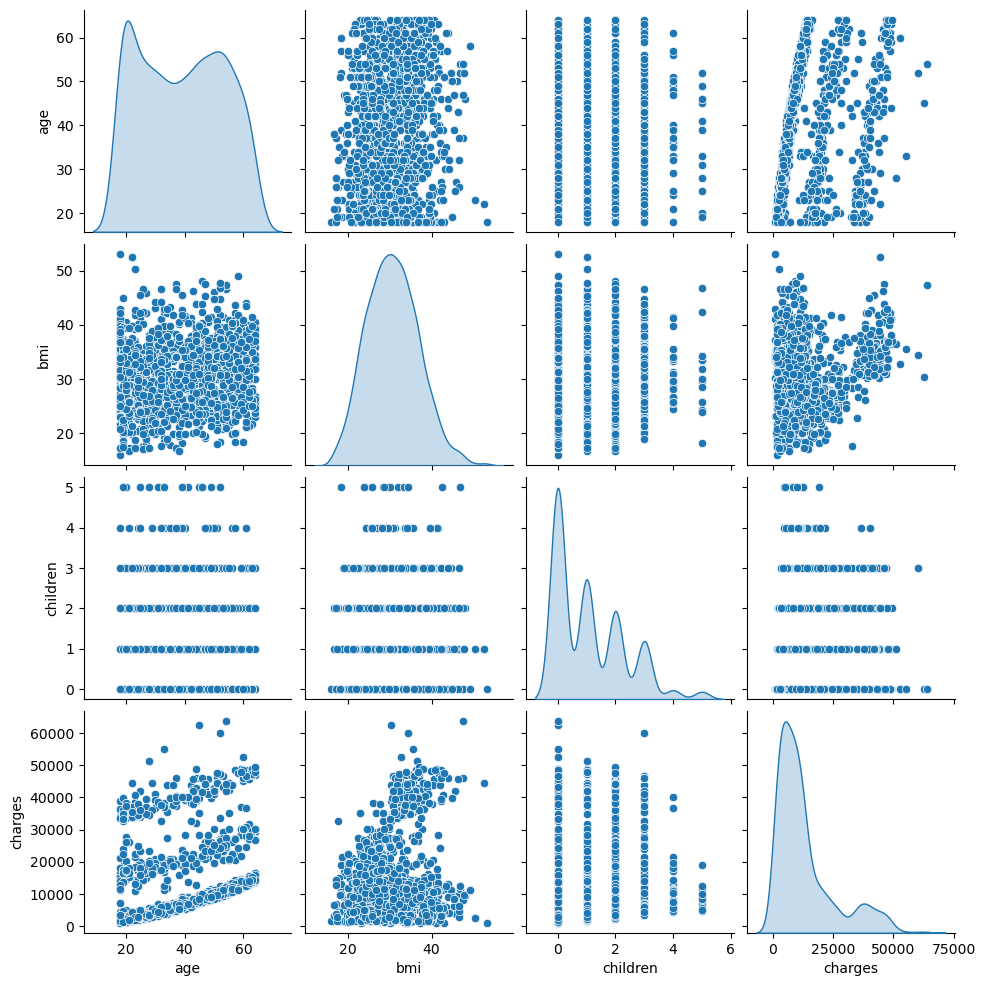

In [304]:
sns.pairplot(train_dataset[['age', 'bmi', 'children', 'charges']], diag_kind='kde')

In [305]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,2218.0,38.957169,14.176141,18.0000,26.00,39.0000,51.000,64.00000
bmi,2218.0,30.676249,6.162375,15.9600,26.18,30.4950,34.800,53.13000
children,2218.0,1.099188,1.211912,0.0000,0.00,1.0000,2.000,5.00000
charges,2218.0,13142.381229,12108.941842,1121.8739,4670.64,9288.0267,16232.847,63770.42801
region_northeast,2218.0,0.238503,0.426264,0.0000,0.00,0.0000,0.000,1.00000
region_northwest,2218.0,0.238503,0.426264,0.0000,0.00,0.0000,0.000,1.00000
region_southeast,2218.0,0.283138,0.450624,0.0000,0.00,0.0000,1.000,1.00000
region_southwest,2218.0,0.239856,0.427092,0.0000,0.00,0.0000,0.000,1.00000
sex_female,2218.0,0.495491,0.500092,0.0000,0.00,0.0000,1.000,1.00000
sex_male,2218.0,0.504509,0.500092,0.0000,0.00,1.0000,1.000,1.00000


# Linear regression with one feature


In [318]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('charges')
test_labels = test_features.pop('charges')

In [323]:
age = np.array(train_features['age'])

# Create a Normalization layer without specifying input_shape
age_normalizer = layers.Normalization(input_shape=[1, ], axis=None)
age_normalizer.adapt(age)

age_model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,)),
    age_normalizer,
    layers.Dense(units=1)
])

age_model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_20                │ (None, 1)              │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 3 (16.00 B)

In [324]:
# Reshape the input to 2D
age_input = age[:10]
age_model.predict(age_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


array([[-1.7638417 ],
       [-1.4103162 ],
       [-0.70326537],
       [-1.7638417 ],
       [ 1.4178873 ],
       [-1.3219349 ],
       [-0.4381213 ],
       [-1.4986976 ],
       [ 0.0037855 ],
       [-1.6754603 ]], dtype=float32)

In [325]:
age_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [326]:
%%time
history = age_model.fit(
    train_features['age'],  # Reshape input
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 7.57 s, sys: 2.21 s, total: 9.78 s
Wall time: 7.95 s


In [327]:
age_model.predict(age[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


array([[576.2424 ],
       [572.9889 ],
       [566.482  ],
       [576.2424 ],
       [546.9612 ],
       [572.17554],
       [564.0419 ],
       [573.80225],
       [559.97504],
       [575.42896]], dtype=float32)

In [328]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,12641.940430,12467.756836,95
96,12636.337891,12462.160156,96
97,12630.742188,12456.561523,97
98,12625.143555,12450.960938,98
99,12619.541992,12445.368164,99


In [329]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 20000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [age]')
  plt.legend()
  plt.grid(True)

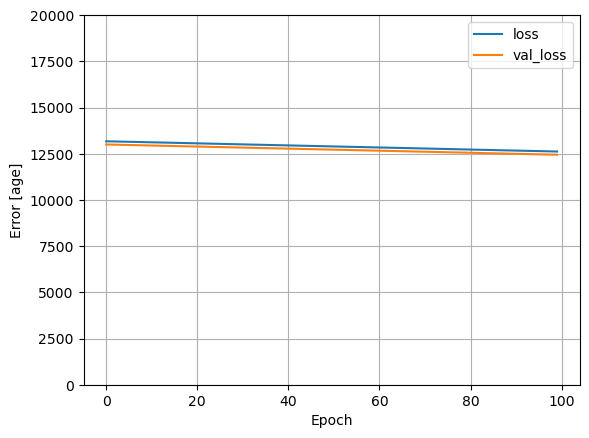

In [330]:
plot_loss(history)

In [331]:
test_results = {}

test_results['age_model'] = age_model.evaluate(
    test_features['age'],
    test_labels, verbose=0)

In [332]:
x = tf.linspace(0.0, 55, 56)
y = age_model.predict(x)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [333]:
def plot_age(x, y):
  plt.scatter(train_features['age'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('age')
  plt.ylabel('charges')
  plt.legend()

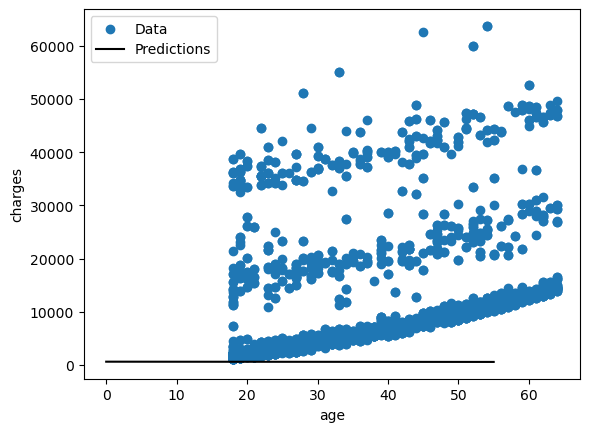

In [334]:
plot_age(x, y)

# Multiple linear regression

## Normalize features

In [348]:
normalizer = tf.keras.layers.Normalization(axis=-1)

## Adapt normalizer to all training features

In [349]:
normalizer.adapt(np.array(train_features))

In [350]:
print(normalizer.mean.numpy())

[[38.95717    30.676249    1.0991884   0.23850316  0.23850316  0.28313795
   0.23985572  0.49549145  0.50450855  0.79891795  0.20108205]]


In [351]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [352]:
linear_model.predict(train_features[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


array([[-1.840302  ],
       [-2.164583  ],
       [-1.6671317 ],
       [ 1.1760318 ],
       [ 0.3832604 ],
       [-0.6313516 ],
       [-0.30618793],
       [-1.8623846 ],
       [ 0.5663985 ],
       [ 2.650527  ]], dtype=float32)

In [353]:
linear_model.layers[1].kernel

<KerasVariable shape=(11, 1), dtype=float32, path=sequential_30/dense_38/kernel>

In [354]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error') 

In [355]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 3.02 s, sys: 1.05 s, total: 4.06 s
Wall time: 2.79 s


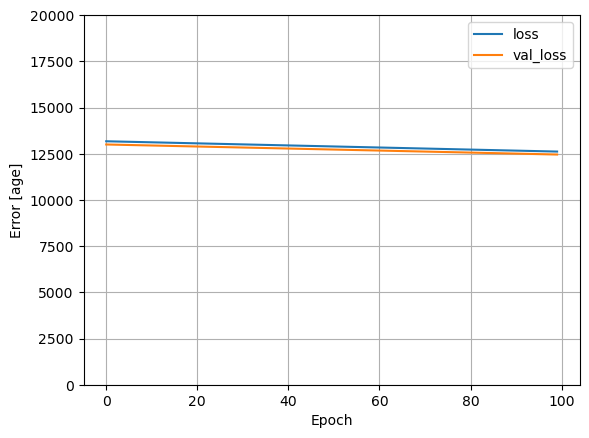

In [356]:
plot_loss(history)

In [357]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

# DNN

In [359]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [360]:
dnn_age_model = build_and_compile_model(age_normalizer)

In [361]:
dnn_age_model.summary()

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_20                │ (None, 1)              │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,356 (17.02 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 3 (16.00 B)

In [362]:
%%time
history = dnn_age_model.fit(
    train_features['age'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 3.64 s, sys: 1.18 s, total: 4.82 s
Wall time: 3.29 s


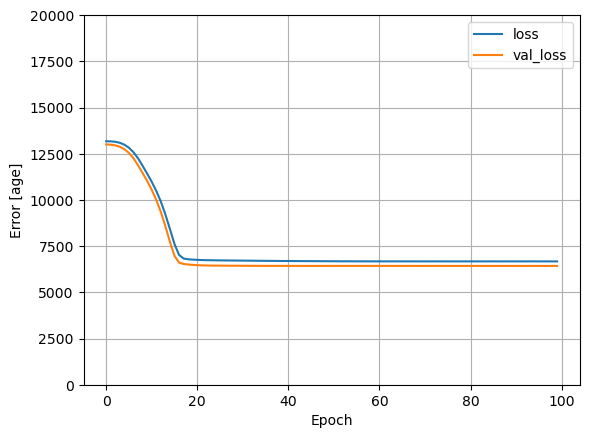

In [363]:
plot_loss(history)

In [364]:
x = tf.linspace(0.0, 250, 251)
y = dnn_age_model.predict(x)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [365]:
test_results['dnn_age_model'] = dnn_age_model.evaluate(
    test_features['age'], test_labels,
    verbose=0)

# Regression using a DNN and multiple inputs

In [366]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_21                │ (10, 11)               │            23 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23 (96.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23 (96.00 B)

In [367]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 3.89 s, sys: 1.17 s, total: 5.06 s
Wall time: 3.35 s


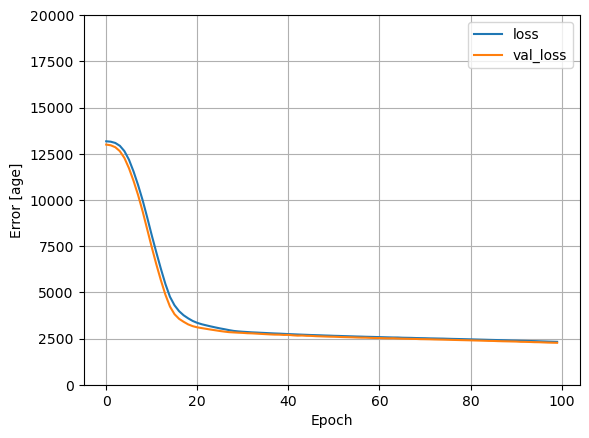

In [368]:
plot_loss(history)

In [369]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [370]:
pd.DataFrame(test_results, index=['Mean absolute error [age]']).T

,Mean absolute error [age]
age_model,13178.367188
linear_model,13186.312500
dnn_age_model,7076.411133
dnn_model,2802.624023


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


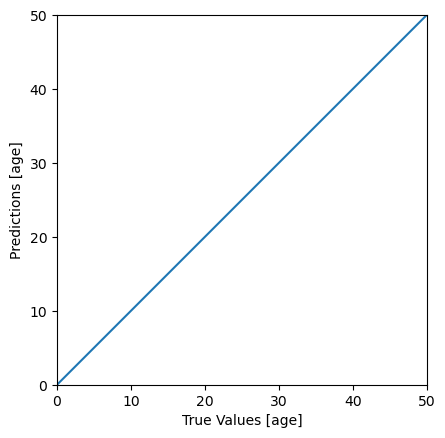

In [371]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [age]')
plt.ylabel('Predictions [age]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

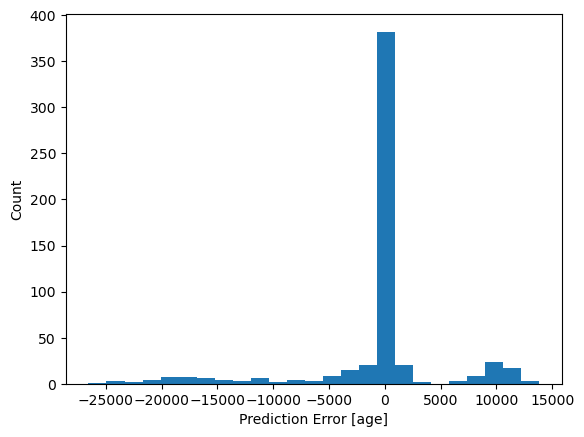

In [372]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [age]')
_ = plt.ylabel('Count')

In [373]:
dnn_model.save('dnn_model.keras')

In [374]:
reloaded = tf.keras.models.load_model('dnn_model.keras')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [375]:
pd.DataFrame(test_results, index=['Mean absolute error [age]']).T

,Mean absolute error [age]
age_model,13178.367188
linear_model,13186.312500
dnn_age_model,7076.411133
dnn_model,2802.624023
reloaded,2802.624023
